In [49]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# Load pretrained model and dataset

In [53]:
#model = models.alexnet(pretrained=True)
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/johannesr/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:40<00:00, 13592395.65it/s]


In [54]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [55]:
valdir = 'data/photos'
dataset = datasets.ImageFolder(valdir, transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)
        ]))

In [56]:
# Transform to apply before feeding the image into the network.
image_means = np.array([0.485, 0.456, 0.406])
image_stds = np.array([0.229, 0.224, 0.225])

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=image_means, std=image_stds)
])

In [57]:
def get_sample(index):
    """Returns the raw image, the transformed image, and the class."""
    raw_image, class_index = dataset[index]
    raw_image = np.array(raw_image)  # convert from PIL to numpy
    image_tensor = input_transform(raw_image)
    return raw_image, image_tensor, class_index

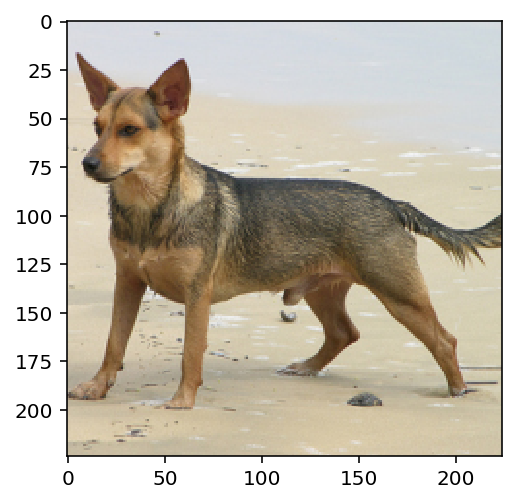

In [58]:
plt.imshow(get_sample(0)[0])

# Interpretation methods

## Backpropagation

In [70]:
# To get the same results as in pytorch-cnn-visualizations (https://github.com/utkuozbulak/pytorch-cnn-visualizations),
# set a fixed target class and do `postprocess=None`.

def sensitivity_analysis(model, image_tensor, target_class=None, postprocess='abs'):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    
    model.eval()
    output = model(X)
    output_class = output.max(1)[1].data.numpy()[0]
    print('Image was classified as:', output_class)
    
    model.zero_grad()
    one_hot_output = torch.zeros(output.size())
    if target_class is None:
        one_hot_output[0, output_class] = 1
    else:
        one_hot_output[0, target_class] = 1
    output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
    else:
        raise ValueError()

## Guided Backpropagation

In [65]:
def guided_backprop(model, image_tensor, target_class=None, postprocess='abs'):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        for pos, module in model.features._modules.items():
            if isinstance(module, nn.ReLU):
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target_class=target_class, postprocess=postprocess)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

## Occlusion

In [66]:
from tqdm import tqdm_notebook

In [67]:
def occlusion(model, image_tensor, target_class=None, size=50, stride=25, show_progress=False):
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=False)  # add dimension to simulate batch
    
    model.eval()
    
    if target_class is None:
        # Get output without occlusion.
        output = model(X)
        target_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', target_class)
        
    width = image_tensor.shape[1]
    height = image_tensor.shape[2]
    
    xs = range(0, width, stride)
    ys = range(0, height, stride)
    
    relevance_map = np.zeros((len(xs), len(ys)))
    
    # TODO: Change this to normal tqdm when refactoring into a module.
    if show_progress:
        xs = tqdm_notebook(xs, desc='x')
        ys = tqdm_notebook(ys, desc='y', leave=False)
    
    for i_x, x in enumerate(xs):
        x_from = max(x - int(size/2), 0)
        x_to = min(x + int(size/2), width)
        
        for i_y, y in enumerate(ys):
            y_from = max(y - int(size/2), 0)
            y_to = min(y + int(size/2), height)
            
            #print('Occluding from x={} to x={} and y={} to y={}'.format(x_from, x_to, y_from, y_to))
            
            image_tensor_occluded = image_tensor.clone()  # TODO: Check how long this takes.
            image_tensor_occluded[:, x_from:x_to, y_from:y_to] = 0
            
            # TODO: Maybe run this batched.
            output = model(Variable(image_tensor_occluded[None], requires_grad=False))
            #print(output.data[0, target_class])
            relevance_map[i_x, i_y] = output.data[0, target_class]
            
    return relevance_map

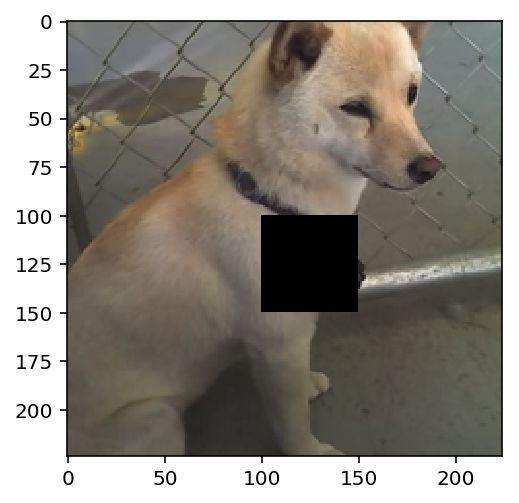

In [68]:
# This is what occlusion looks like.
image, image_tensor, class_index = get_sample(1)
image_occluded = image.copy()
size = 50
image_occluded[100:100+size, 100:100+size] = 0
plt.imshow(image_occluded)

## Grad-CAM

In [60]:
from scipy import ndimage

def resize_image(img, size, interpolation=0):
    """Resize img to size. Interpolation between 0 and 5."""
    zoom_factors = np.asarray(size) / np.asarray(img.shape)
    return sp.ndimage.zoom(img, zoom_factors, order=interpolation)

In [61]:
def all_children(model):
    children = list(model.children())
    for child in model.children():
        children.extend(all_children(child))
    return children

In [98]:
def grad_cam(model, image_tensor, target_class=None, last_conv_layer=None, resize=False, interpolation=1):
    
    image_tensor = torch.Tensor(image_tensor)
    X = Variable(image_tensor[None], requires_grad=False)  # add dimension to simulate batch
    
    # Step 1: Find the last conv layer if it is not set manually.
    if last_conv_layer is None:
        for module in all_children(model)[::-1]:  # traverse model backwards
            if type(module) == nn.Conv1d or type(module) == nn.Conv2d or type(module) == nn.Conv3d:
                last_conv_layer = module
                print('Found last conv layer:', last_conv_layer)
                break
        if last_conv_layer is None:
            raise ValueError('Could not find last conv layer automatically, please set it manually')
    
    
    # Step 2: Register hooks on the last conv layer to store the (forward) feature maps and the gradient.
    store = {}  # hacky way to store values in this function from hooks
    
    def feature_maps_hook(module, input, output):
        store['feature_maps'] = output.data.numpy()[0]
        
    def gradient_hook(module, grad_in, grad_out):
        store['gradient'] = grad_out[0].data.numpy()[0]
        
    hook_handle_forward = last_conv_layer.register_forward_hook(feature_maps_hook)
    hook_handle_backward = last_conv_layer.register_backward_hook(gradient_hook)
    
    try:
        # Step 3: Run model forward (will store feature maps of the last conv layer).
        model.eval()
        output = model(X)
        output_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', output_class)
        #print(store['feature_maps'].shape)
        
        # Step 4: Run model backwards (will store gradient of the last conv layer).
        model.zero_grad()
        one_hot_output = torch.zeros(output.size())
        if target_class is None:
            one_hot_output[0, output_class] = 1
        else:
            one_hot_output[0, target_class] = 1
        output.backward(gradient=one_hot_output)
        #print(one_hot_output)
        
        # Step 5: Calculate CAM as linear combination of each feature map and its averaged gradient.
        coefficients = store['gradient'].mean(axis=tuple(range(1, store['gradient'].ndim)), keepdims=True)
        print(coefficients.shape)
        print(store['feature_maps'].shape)
        cam = (coefficients * store['feature_maps']).sum(axis=0)
        print(np.min(cam), np.mean(cam), np.max(cam))
        cam = np.maximum(cam, 0)
        print(np.min(cam), np.mean(cam), np.max(cam))
        
        vmin = np.min(coefficients * store['feature_maps'])
        vmax = np.max(coefficients * store['feature_maps'])
        for fm, g, c in zip(store['feature_maps'], store['gradient'], coefficients.flatten()):
            #utils.plot_slices(fm*c, num_slices=3, vmin=vmin, vmax=vmax)
            if c in sorted(coefficients, reverse=True)[:5]:
                print(c)
                plt.figure()
                plt.imshow(fm*c, vmin=vmin, vmax=vmax)
                plt.colorbar()
        
        if resize:
            cam = resize_image(cam, image_tensor.shape[1:], interpolation=interpolation)
        
        return cam
        
    finally:
        hook_handle_forward.remove()
        hook_handle_backward.remove()
        del hook_handle_forward, hook_handle_backward

Found last conv layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Image was classified as: 227
(512, 1, 1)
(512, 14, 14)
-0.0356089 -0.00137993 0.0809505
0.0 0.00583142 0.0809505
0.0138893
0.0109557
0.00974201
0.00769611
0.00898885


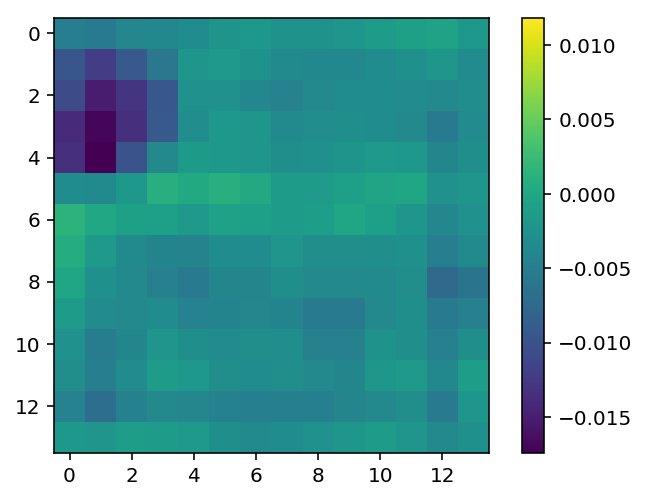

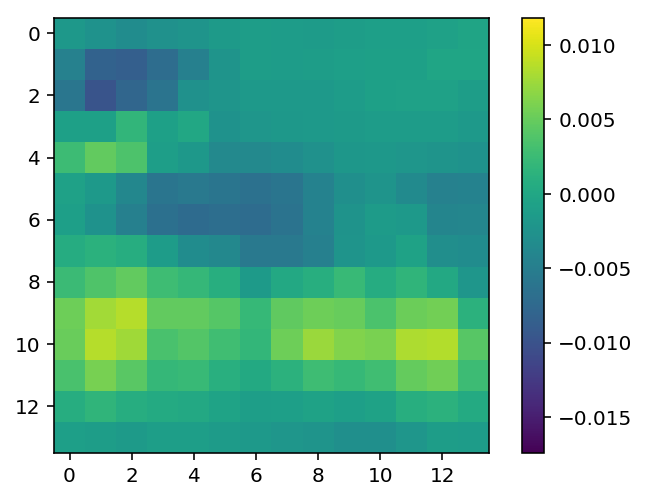

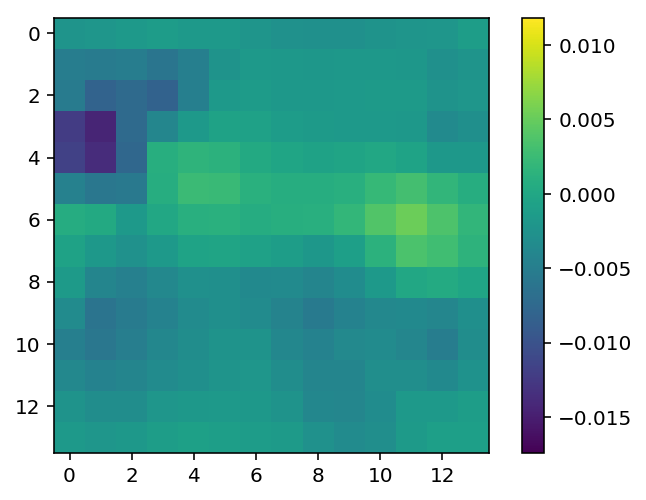

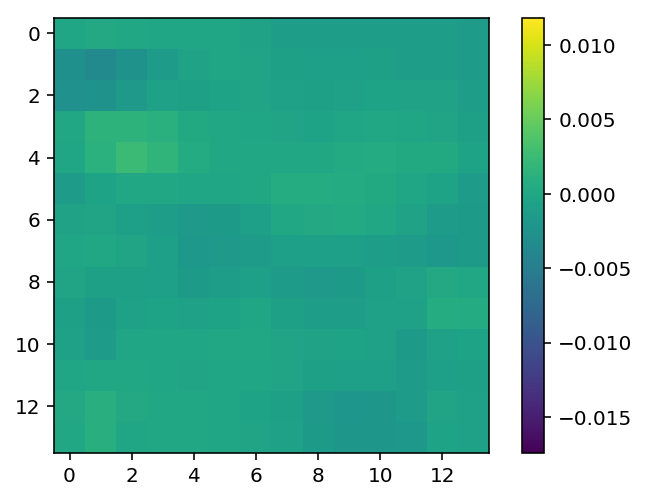

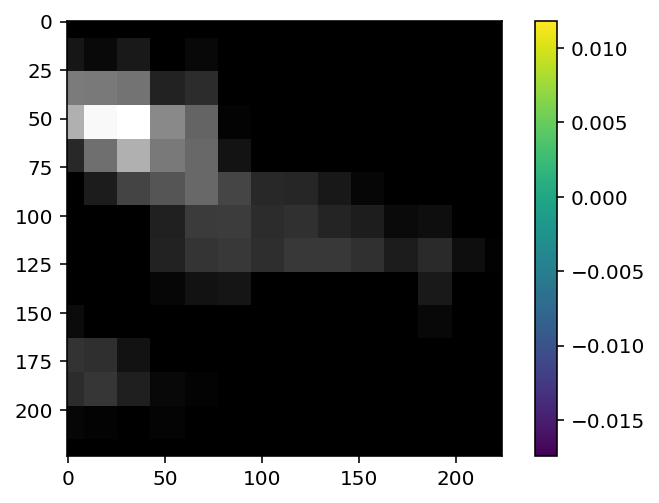

In [99]:
image, image_tensor, class_index = get_sample(0)
plt.imshow(grad_cam(model, image_tensor, resize=True, interpolation=0), cmap='gray')

In [74]:
grad_cam(model, image_tensor, resize=True, interpolation=0)

Found last conv layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Image was classified as: 273
(512, 1, 1)
(512, 14, 14)
-0.0691144 -0.0139574 0.151971
0.0 0.00691916 0.151971


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.00873572,  0.00873572,  0.00873572, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00873572,  0.00873572,  0.00873572, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00873572,  0.00873572,  0.00873572, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

# Compare all methods

Image was classified as: 227
Image was classified as: 227
Image was classified as: 227
Found last conv layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Image was classified as: 227
(512, 1, 1)
(512, 14, 14)
-0.0356089 -0.00137993 0.0809505
0.0 0.00583142 0.0809505
Image was classified as: 273
Image was classified as: 273
Image was classified as: 273


KeyboardInterrupt: 

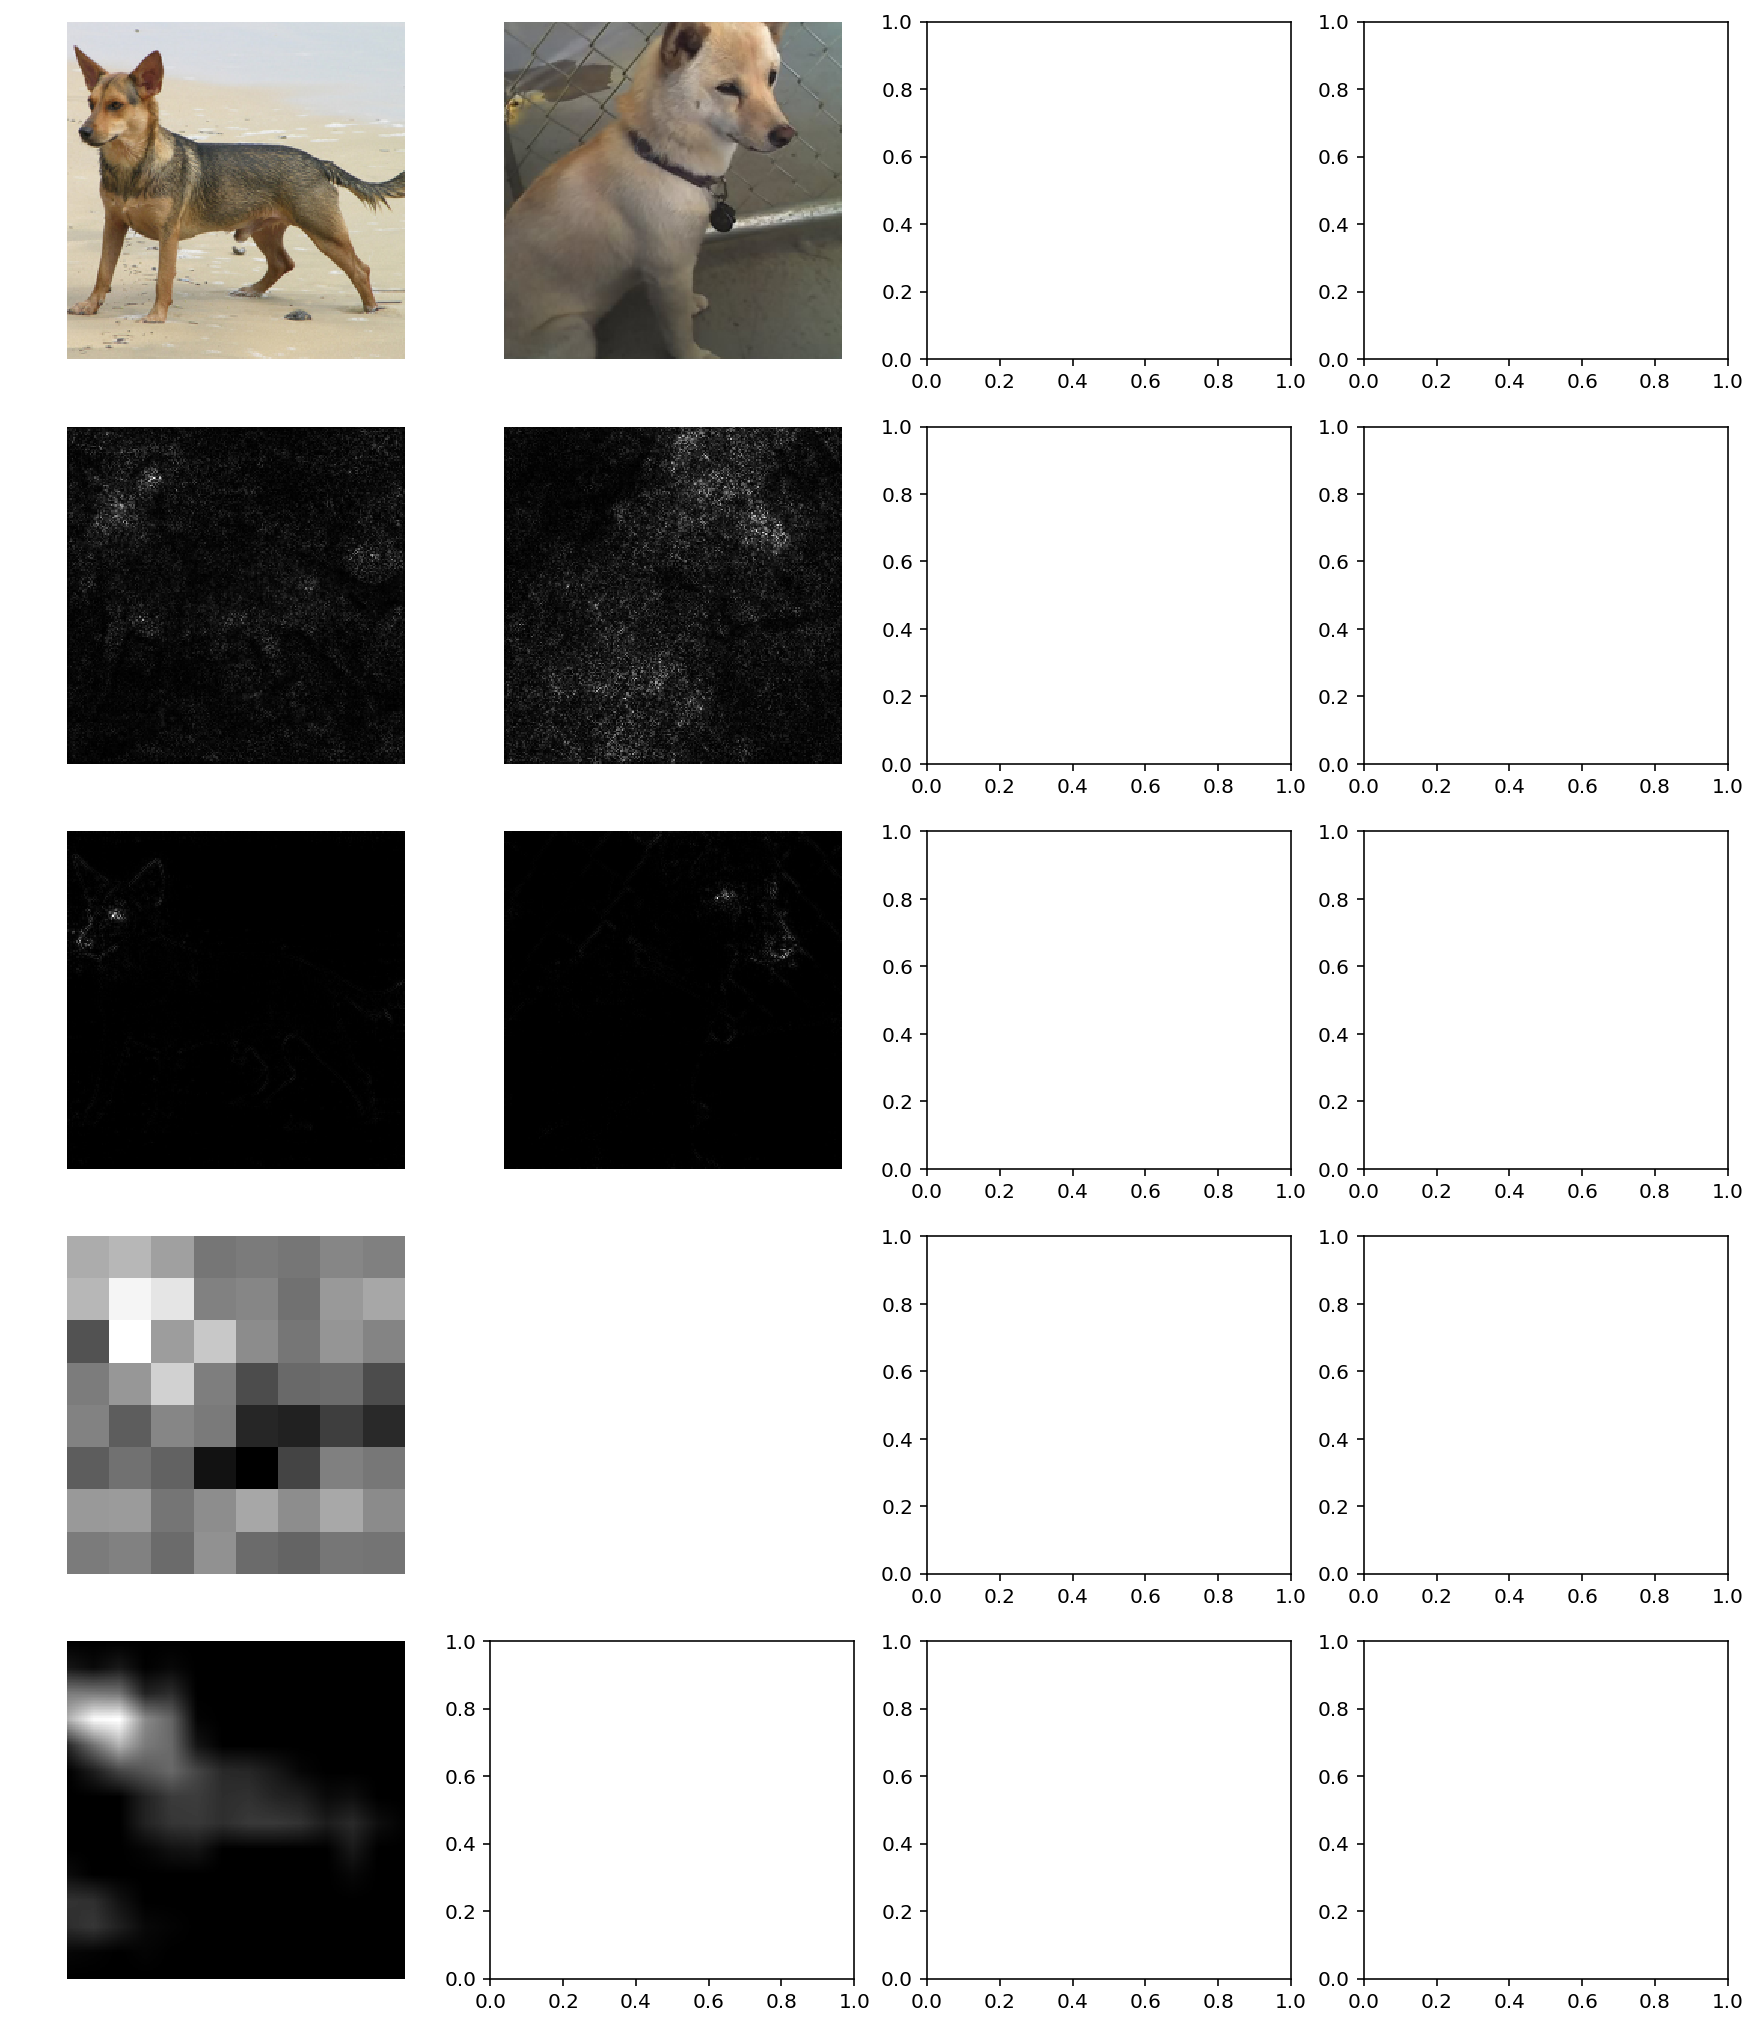

In [73]:
fig, axes = plt.subplots(5, 4, figsize=(15, 18))

offset = 0  # which image in the dataset to start with

for i, vertical_axes in enumerate(axes.T):
    image, image_tensor, class_index = get_sample(i+offset)
    
    plt.sca(vertical_axes[0])
    plt.axis('off')
    plt.imshow(image)
    
    plt.sca(vertical_axes[1])
    plt.axis('off')
    plt.imshow(sensitivity_analysis(model, image_tensor, postprocess='abs').max(0), cmap='gray')
    
    plt.sca(vertical_axes[2])
    plt.axis('off')
    plt.imshow(guided_backprop(model, image_tensor, postprocess='abs').max(0), cmap='gray')
    
    plt.sca(vertical_axes[3])
    plt.axis('off')
    plt.imshow(occlusion(model, image_tensor, size=50, stride=30), cmap='Greys')
    
    plt.sca(vertical_axes[4])
    plt.axis('off')
    plt.imshow(grad_cam(model, image_tensor, resize=True, interpolation=1), cmap='gray')

plt.tight_layout()

- 1st row: Image
- 2nd row: Backprop
- 3rd row: Guided Backprop
- 4th row: Occlusion
- 5th row: Grad-CAM